In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
import scipy.fftpack

In [56]:
(r, audio1) = wav.read('midC.wav.wav') # take frequency & audio data 

# 1 (currently getting used to the process using single keyboard notes)

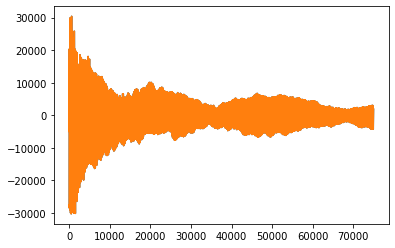

In [59]:
# ***function to determine correct starting time (cut out the silence before)********************************************
    # for now, just doing it manually to test everything else

audio = audio1[int(1.3*r):int(3*r)]
plt.plot(audio) # plot the audio waves over a time interval

Transform

In [60]:
audio2 = audio[:,0] # take the second entry in each row

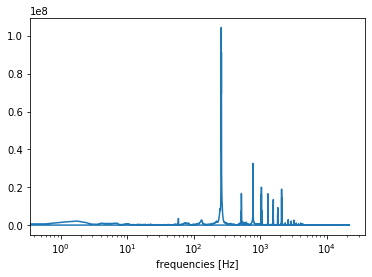

In [72]:
audioft = fft(audio2) # transform
audioft2 = abs(audioft) # absolute value for plotting
freq = fftfreq(len(audioft2), 1/r) # get frequencies; window length = length of the audio file (after trimmed), sample spacing = 1/rate
plt.xlabel('frequencies [Hz]')
plt.xscale('log')
plt.plot(freq, audioft2)

In [ ]:
# ***Now with chords!!!!***********************************************************************************************

# 2: Processing the notes

In [ ]:
# ***BIG TASK: filter out harmonic frequencies*************************************************************************
# ***BIG TASK: filter out extra noise from the instrument/environment**************************************************
# ***return an array of the 3 or 4 frequencies

Returning the frequencies as notes (i.e. 440 --> A)

In [217]:
Notes = [["C",261.63,1],["C#",277.18,2],["D",293.66,3],["D#",311.13,4],["E",329.63,5],["F",349.23,6],["F#",369.99,7],["G",392,8],["G#",415.3,9],["A",440,10],["A#",466.16,11],["B",493.88,0]]
letters = [i[0] for i in Notes]
fs = [float(i[1]) for i in Notes]
nums = [i[2] for i in Notes]

# ***function that sets the frequency to the correct range (~ 250 to 500), i.e. picks one standard octave*******************************************************************

def freq_notes(freq_array):
    notes_data = []
    for i in freq_array:
        diff = [j-i for j in fs] # subtract freq from the note array's 2nd entries
        abs_diff = np.abs(diff) 
        kmin = 2
        for k in range(0,12):
            if abs_diff[k] < abs_diff[kmin]:
                kmin = k
        notes_data.append(Notes[kmin])
    return(notes_data)

test = np.array([266,330,393])
notes_data_test = freq_notes(test)
print(notes_data_test)

[['C', 261.63, 1], ['E', 329.63, 5], ['G', 392, 8]]


Determine what the chord is & print out its name + notes

Using the 9 common chord types:

* Major triad (0,4,7)
* Minor triad (0,3,7)
* Diminished (0,3,6)
* Major seventh (0,4,7,11)
* Minor Seventh (0,3,7,10)
* Dominant Seventh (0,4,7,10)
* Suspended: sus2 (0,2,7), sus4 (0,5,7)
* Augmented (0,4,8)
* Won't be doing extended / inversions (squish everything into one octave)

In [218]:
#Test chords

A_minor7 = freq_notes((261.63, 329.63, 392, 440))
print(A_minor7)

G_sus4 = freq_notes((390,261.63,294))
print(G_sus4)

[['C', 261.63, 1], ['E', 329.63, 5], ['G', 392, 8], ['A', 440, 10]]
[['G', 392, 8], ['C', 261.63, 1], ['D', 293.66, 3]]


In [219]:
def notes_chord(notes_data): # takes the collection of notes and matches it to the chord it is (not in key)
    nums = [i[2] for i in notes_data]
    for i in nums:
        chord_i = [(j-i)%12 for j in nums] # mod 12
        chord_i.sort() # put in numerical order
        chord_nums = [(j+i)%12 for j in chord_i] # adding i back, mod 12, gives the OG notes but in the right order
        chord_letters = [letters[i][0] for i in chord_nums]
        if len(chord_i) == 3:
            chord2 = np.append(chord_i,0)
        if chord2[1]==2 and chord2[2]==7 and chord2[3]==0:
            return(chord_nums,chord_letters, "%i sus2" %i) # *** change i value to letter value **************************************************
        if chord2[1] == 3:
            if chord2[2] == 7 and chord2[3] == 0:
                return(chord_nums,chord_letters, "%i minor" %i)
            if chord2[2] == 6 and chord2[3] == 0:
                return(chord_nums,chord_letters, "%i diminished" %i)
            if chord2[2] == 7 and chord2[3] == 10:
                return(chord_nums,chord_letters, "%i minor seventh" %i)
        if chord2[1] == 4:
            if chord2[2] == 7 and chord2[3] == 0:
                return(chord_nums,chord_letters, "%i major" %i)
            if chord2[2] == 7 and chord2[3] == 11:
                return(chord_nums,chord_letters, "%i major seventh" %i)
            if chord2[2] == 7 and chord2[3] == 10:
                return(chord_nums,chord_letters, "%i dominant seventh" %i)
            if chord2[2] == 8 and chord2[3] == 0:
                return(chord_nums,chord_letters, "%i augmented" %i)
        if chord2[1]==5 and chord2[2]==7 and chord2[3]==0:
            return(chord_nums,chord_letters, "%i sus4" %i)

notes_chord_test_Gsus4 = notes_chord(G_sus4)
print(notes_chord_test_Gsus4)

([8, 1, 3], ['G', 'C', 'D'], '8 sus4')


# 3: Picking the right keys

“elimination round” sort of function that checks which keys have the first note, and then of those remaining, checks which have the second, etc.
* just using major & natural minor keys

If not too complicated, lower threshold to allow just 3 of the 4 notes to fit into the key which allows some more chord combinations to be considered

In [262]:
Cn_an = [1,3,5,6,8,10,12]
Cs_as = [(i+1)%12 for i in Cn_an]
Dn_bn = [(i+2)%12 for i in Cn_an]
# Each row of the array is the scale of notes in that key (i.e. row 1 is the C major / A minor notes, row 2 is C#M/A#m, etc.)

def findmykeys(notes_chord):
    keys=[]
    tonics = np.arange(1,13) # set integers 1 to 12 to represent the major key tonics
    for i in notes_chord[0]: 
        for j in tonics:
            key_j = [(j+n-1)%12 for n in Cn_an] # check which keys contain i (j=1 --> C, j=12 --> B)
            if i not in key_j: # if the key doesn't contains i it gets set to 0
                tonics[j-1]=0
    for j in tonics:
        if j > 0:
            keys.append("%i Major" %j) # ***make it be letters not numbers **********************************************
            keys.append("%i Minor" %((j+9)%12))
    return(keys)

findmykeys(notes_chord_test_Gsus4) # should get CM=am (1,10), GM=em (8,5), FM=dm(6,3), BfM/AsM=gm (11,8), EfM/DsM=cm (4,1)

['1 Major',
 '10 Minor',
 '4 Major',
 '1 Minor',
 '6 Major',
 '3 Minor',
 '8 Major',
 '5 Minor',
 '11 Major',
 '8 Minor']

# 4: for each key, determining where in the key that chord fits

* a chord relative to a key just becomes a matter of numerical difference.
* For example, if the key is C major and the chord is G major, the key's tonic is C=1. The notes are G=8, B=12 and D=3. So the chord, relative to C major, is defined as the notes that have a "difference" of 7, 11, and 2 half-steps from the tonic, in other words the V chord (though I'm realizing this means if the key has something like B=12 as its tonic, then C=1 would be a difference of 1, so mod12 is going to come into play here).


In [ ]:
def lockinkey(key,chord): # for each key, determine where the chord "locks" in #yaypuns *******************************
    # 

# 5: hearing that chord fit into a chosen key:

* figure out how to do playback of a standard 1 chord for an inputted key (still need to do some more looking into this to see if/how it's possible), followed by the playback of the chord that was entered in step 1, followed by the 1 chord again


# 6: Bringing it all together in one function